## Setting up
- Notebook: `SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)` 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/"My Drive"/OML

/content/drive/My Drive/OML


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# hyperparameters
BATCH_SIZE = 64

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])) 

Files already downloaded and verified


In [ ]:
# sampling for smaller dataset: train
TRAIN_SAMPLES = int(len(train_set) / (10 * 2))
train_class_seen = dict([(i, 0) for i in range(10)])
train_indices = []
for i, (_, l) in enumerate(train_set):
  if train_class_seen[l] >= TRAIN_SAMPLES:
    continue
  train_class_seen[l] += 1
  train_indices.append(i)
train_subset = torch.utils.data.Subset(train_set, train_indices)
len(train_subset)

25000

In [ ]:
# sampling for smaller dataset: test
TEST_SAMPLES = int(len(test_set) / (10 * 3))
test_class_seen = dict([(i, 0) for i in range(10)])
test_indices = []
for i, (_, l) in enumerate(test_set):
  if test_class_seen[l] >= TEST_SAMPLES:
    continue
  test_class_seen[l] += 1
  test_indices.append(i)
test_subset = torch.utils.data.Subset(test_set, test_indices)
# store the test set as a single tensor
test_X, test_Y = [], []
for s, l in test_subset:
  test_X.append(s)
  test_Y.append(l)
test_X = torch.stack(test_X).float()
test_Y = torch.tensor(test_Y).long()
test_X, test_Y = test_X.to(device), test_Y.to(device)
test_X.shape, test_Y.shape

(torch.Size([3330, 3, 32, 32]), torch.Size([3330]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Analysis

In [ ]:
sample_image, sample_label = train_set[100]

In [ ]:
sample_image.shape

torch.Size([3, 32, 32])

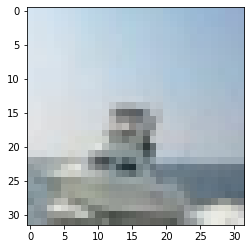

In [ ]:
plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
len(train_set), len(test_set)

(50000, 10000)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Linear(in_features=32*15*15, out_features=600),
        nn.ReLU(),
        nn.Linear(in_features=600, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=10)
    )
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.lin(out)
    out = self.softmax(out)
    return out
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=7200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# hyperparameters
NUM_EPOCHS = 100

In [ ]:
error = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

## Training

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 58.34it/s]


Performace at epoch 1
Train Loss: 1.91651 ; Train Acc: 0.29744
Test Loss: 1.67284 ; Test Acc: 0.38018


100%|██████████| 391/391 [00:06<00:00, 59.87it/s]


Performace at epoch 2
Train Loss: 1.47208 ; Train Acc: 0.46612
Test Loss: 1.37281 ; Test Acc: 0.51381


100%|██████████| 391/391 [00:06<00:00, 58.94it/s]


Performace at epoch 3
Train Loss: 1.27764 ; Train Acc: 0.54372
Test Loss: 1.27009 ; Test Acc: 0.54655


100%|██████████| 391/391 [00:06<00:00, 59.94it/s]


Performace at epoch 4
Train Loss: 1.14203 ; Train Acc: 0.59444
Test Loss: 1.22559 ; Test Acc: 0.54985


100%|██████████| 391/391 [00:06<00:00, 59.66it/s]


Performace at epoch 5
Train Loss: 1.01385 ; Train Acc: 0.64048
Test Loss: 1.15299 ; Test Acc: 0.59069


100%|██████████| 391/391 [00:06<00:00, 58.32it/s]


Performace at epoch 6
Train Loss: 0.88136 ; Train Acc: 0.68824
Test Loss: 1.14171 ; Test Acc: 0.59940


100%|██████████| 391/391 [00:06<00:00, 58.32it/s]


Performace at epoch 7
Train Loss: 0.73905 ; Train Acc: 0.73980
Test Loss: 1.13834 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:06<00:00, 58.57it/s]


Performace at epoch 8
Train Loss: 0.58770 ; Train Acc: 0.79256
Test Loss: 1.18246 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:06<00:00, 59.15it/s]


Performace at epoch 9
Train Loss: 0.43534 ; Train Acc: 0.84976
Test Loss: 1.28610 ; Test Acc: 0.61742


100%|██████████| 391/391 [00:06<00:00, 58.76it/s]


Performace at epoch 10
Train Loss: 0.29930 ; Train Acc: 0.89736
Test Loss: 1.45545 ; Test Acc: 0.60390


100%|██████████| 391/391 [00:06<00:00, 59.22it/s]


Performace at epoch 11
Train Loss: 0.20954 ; Train Acc: 0.93212
Test Loss: 1.67238 ; Test Acc: 0.60090


100%|██████████| 391/391 [00:06<00:00, 59.23it/s]


Performace at epoch 12
Train Loss: 0.15321 ; Train Acc: 0.94996
Test Loss: 1.81380 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:06<00:00, 58.96it/s]


Performace at epoch 13
Train Loss: 0.11678 ; Train Acc: 0.96304
Test Loss: 1.98485 ; Test Acc: 0.59880


100%|██████████| 391/391 [00:06<00:00, 60.09it/s]


Performace at epoch 14
Train Loss: 0.09963 ; Train Acc: 0.96832
Test Loss: 2.05886 ; Test Acc: 0.61141


100%|██████████| 391/391 [00:06<00:00, 60.18it/s]


Performace at epoch 15
Train Loss: 0.08999 ; Train Acc: 0.97124
Test Loss: 2.22211 ; Test Acc: 0.60210


100%|██████████| 391/391 [00:06<00:00, 59.76it/s]


Performace at epoch 16
Train Loss: 0.08381 ; Train Acc: 0.97312
Test Loss: 2.20119 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:06<00:00, 59.75it/s]


Performace at epoch 17
Train Loss: 0.07358 ; Train Acc: 0.97672
Test Loss: 2.27436 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:06<00:00, 58.84it/s]


Performace at epoch 18
Train Loss: 0.06136 ; Train Acc: 0.98024
Test Loss: 2.29922 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:06<00:00, 58.47it/s]


Performace at epoch 19
Train Loss: 0.05112 ; Train Acc: 0.98328
Test Loss: 2.65621 ; Test Acc: 0.60841


100%|██████████| 391/391 [00:06<00:00, 57.00it/s]


Performace at epoch 20
Train Loss: 0.04588 ; Train Acc: 0.98548
Test Loss: 2.63537 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:06<00:00, 56.17it/s]


Performace at epoch 21
Train Loss: 0.04506 ; Train Acc: 0.98540
Test Loss: 2.69474 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:06<00:00, 56.50it/s]


Performace at epoch 22
Train Loss: 0.04170 ; Train Acc: 0.98692
Test Loss: 3.01066 ; Test Acc: 0.59970


100%|██████████| 391/391 [00:06<00:00, 58.02it/s]


Performace at epoch 23
Train Loss: 0.04410 ; Train Acc: 0.98604
Test Loss: 2.64843 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:06<00:00, 57.80it/s]


Performace at epoch 24
Train Loss: 0.03252 ; Train Acc: 0.98956
Test Loss: 2.67135 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:06<00:00, 57.72it/s]


Performace at epoch 25
Train Loss: 0.01925 ; Train Acc: 0.99480
Test Loss: 2.90357 ; Test Acc: 0.60991


100%|██████████| 391/391 [00:06<00:00, 57.85it/s]


Performace at epoch 26
Train Loss: 0.01587 ; Train Acc: 0.99580
Test Loss: 2.81118 ; Test Acc: 0.61051


100%|██████████| 391/391 [00:06<00:00, 56.28it/s]


Performace at epoch 27
Train Loss: 0.00654 ; Train Acc: 0.99836
Test Loss: 2.83927 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 56.45it/s]


Performace at epoch 28
Train Loss: 0.00128 ; Train Acc: 0.99988
Test Loss: 2.85323 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 57.29it/s]


Performace at epoch 29
Train Loss: 0.00059 ; Train Acc: 0.99992
Test Loss: 2.89772 ; Test Acc: 0.63123


100%|██████████| 391/391 [00:06<00:00, 57.52it/s]


Performace at epoch 30
Train Loss: 0.00035 ; Train Acc: 0.99996
Test Loss: 2.93356 ; Test Acc: 0.63393


100%|██████████| 391/391 [00:06<00:00, 57.02it/s]


Performace at epoch 31
Train Loss: 0.00033 ; Train Acc: 1.00000
Test Loss: 2.98653 ; Test Acc: 0.63333


100%|██████████| 391/391 [00:06<00:00, 57.91it/s]


Performace at epoch 32
Train Loss: 0.00024 ; Train Acc: 1.00000
Test Loss: 2.99485 ; Test Acc: 0.63423


100%|██████████| 391/391 [00:06<00:00, 57.96it/s]


Performace at epoch 33
Train Loss: 0.00021 ; Train Acc: 1.00000
Test Loss: 3.01289 ; Test Acc: 0.63363


100%|██████████| 391/391 [00:06<00:00, 58.26it/s]


Performace at epoch 34
Train Loss: 0.00019 ; Train Acc: 1.00000
Test Loss: 3.02962 ; Test Acc: 0.63453


100%|██████████| 391/391 [00:06<00:00, 58.04it/s]


Performace at epoch 35
Train Loss: 0.00017 ; Train Acc: 1.00000
Test Loss: 3.04441 ; Test Acc: 0.63604


100%|██████████| 391/391 [00:06<00:00, 57.93it/s]


Performace at epoch 36
Train Loss: 0.00016 ; Train Acc: 1.00000
Test Loss: 3.06176 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Performace at epoch 37
Train Loss: 0.00015 ; Train Acc: 1.00000
Test Loss: 3.07448 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 57.19it/s]


Performace at epoch 38
Train Loss: 0.00014 ; Train Acc: 1.00000
Test Loss: 3.09044 ; Test Acc: 0.63453


100%|██████████| 391/391 [00:06<00:00, 58.19it/s]


Performace at epoch 39
Train Loss: 0.00013 ; Train Acc: 1.00000
Test Loss: 3.10127 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 58.61it/s]


Performace at epoch 40
Train Loss: 0.00012 ; Train Acc: 1.00000
Test Loss: 3.11204 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 58.49it/s]


Performace at epoch 41
Train Loss: 0.00012 ; Train Acc: 1.00000
Test Loss: 3.12446 ; Test Acc: 0.63453


100%|██████████| 391/391 [00:06<00:00, 58.49it/s]


Performace at epoch 42
Train Loss: 0.00011 ; Train Acc: 1.00000
Test Loss: 3.13455 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 59.59it/s]


Performace at epoch 43
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.14427 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 59.11it/s]


Performace at epoch 44
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.15228 ; Test Acc: 0.63604


100%|██████████| 391/391 [00:06<00:00, 56.77it/s]


Performace at epoch 45
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.16407 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 57.66it/s]


Performace at epoch 46
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.17140 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 57.20it/s]


Performace at epoch 47
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.18188 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 60.15it/s]


Performace at epoch 48
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.18958 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 59.88it/s]


Performace at epoch 49
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.19876 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 59.65it/s]


Performace at epoch 50
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.20453 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 59.94it/s]


Performace at epoch 51
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.21263 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 60.53it/s]


Performace at epoch 52
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.21983 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 60.19it/s]


Performace at epoch 53
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.22592 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 60.12it/s]


Performace at epoch 54
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.23115 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 60.10it/s]


Performace at epoch 55
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.23911 ; Test Acc: 0.63604


100%|██████████| 391/391 [00:06<00:00, 59.95it/s]


Performace at epoch 56
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.24572 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 59.18it/s]


Performace at epoch 57
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.25219 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 57.27it/s]


Performace at epoch 58
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.25588 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 59.81it/s]


Performace at epoch 59
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.26183 ; Test Acc: 0.63724


100%|██████████| 391/391 [00:06<00:00, 60.05it/s]


Performace at epoch 60
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.26801 ; Test Acc: 0.63604


100%|██████████| 391/391 [00:06<00:00, 60.34it/s]


Performace at epoch 61
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.27363 ; Test Acc: 0.63724


100%|██████████| 391/391 [00:06<00:00, 59.99it/s]


Performace at epoch 62
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.27835 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:06<00:00, 59.28it/s]


Performace at epoch 63
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.28501 ; Test Acc: 0.63694


100%|██████████| 391/391 [00:06<00:00, 60.17it/s]


Performace at epoch 64
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.29012 ; Test Acc: 0.63694


100%|██████████| 391/391 [00:06<00:00, 59.99it/s]


Performace at epoch 65
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.29377 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.66it/s]


Performace at epoch 66
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.29925 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Performace at epoch 67
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.30333 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.18it/s]


Performace at epoch 68
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.30849 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:06<00:00, 59.31it/s]


Performace at epoch 69
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.31185 ; Test Acc: 0.63784


100%|██████████| 391/391 [00:06<00:00, 59.21it/s]


Performace at epoch 70
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.31600 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 59.92it/s]


Performace at epoch 71
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.32087 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 59.15it/s]


Performace at epoch 72
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.32459 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:06<00:00, 58.64it/s]


Performace at epoch 73
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.32876 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 58.76it/s]


Performace at epoch 74
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.33404 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


Performace at epoch 75
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.33704 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 57.42it/s]


Performace at epoch 76
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.34092 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 57.39it/s]


Performace at epoch 77
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.34490 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 58.44it/s]


Performace at epoch 78
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.34916 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.22it/s]


Performace at epoch 79
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.35292 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 58.95it/s]


Performace at epoch 80
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.35718 ; Test Acc: 0.63784


100%|██████████| 391/391 [00:06<00:00, 59.04it/s]


Performace at epoch 81
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.35917 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:06<00:00, 59.00it/s]


Performace at epoch 82
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.36288 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 58.86it/s]


Performace at epoch 83
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.36716 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:06<00:00, 58.31it/s]


Performace at epoch 84
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.37076 ; Test Acc: 0.63784


100%|██████████| 391/391 [00:06<00:00, 59.04it/s]


Performace at epoch 85
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.37431 ; Test Acc: 0.63784


100%|██████████| 391/391 [00:06<00:00, 58.35it/s]


Performace at epoch 86
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.37808 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 58.55it/s]


Performace at epoch 87
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.38004 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 59.55it/s]


Performace at epoch 88
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.38391 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.58it/s]


Performace at epoch 89
Train Loss: 0.00004 ; Train Acc: 1.00000
Test Loss: 3.38765 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.47it/s]


Performace at epoch 90
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.39002 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.28it/s]


Performace at epoch 91
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.39382 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.27it/s]


Performace at epoch 92
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.39587 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 58.83it/s]


Performace at epoch 93
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.39909 ; Test Acc: 0.63784


100%|██████████| 391/391 [00:06<00:00, 59.25it/s]


Performace at epoch 94
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.40255 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 58.78it/s]


Performace at epoch 95
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.40549 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 58.23it/s]


Performace at epoch 96
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.40887 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 58.11it/s]


Performace at epoch 97
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.41036 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 58.63it/s]


Performace at epoch 98
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.41340 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


Performace at epoch 99
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.41738 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 58.32it/s]

Performace at epoch 100
Train Loss: 0.00003 ; Train Acc: 1.00000
Test Loss: 3.41954 ; Test Acc: 0.63844


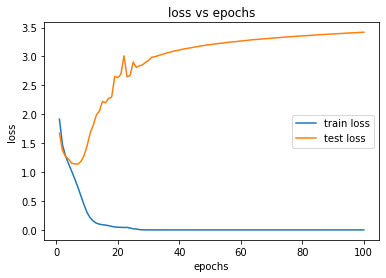

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

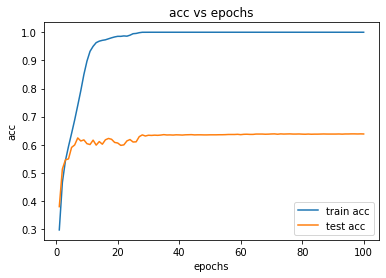

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()

## Hyperparameter tuning
- For a set of hyperparameters, various trials with different models are trained based on randomly-sampled or exhaustive hyperparameters upto a certain number of epochs (dependent on lr). Finally the best set of hyperparameters are chosen which correspond to the minimum testing loss after training.

In [ ]:
import decimal

In [ ]:
HYPERPARAMS = {
    'lr': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001],
    'momentum': [0.3, 0.5, 0.7, 0.9, 0.99]
}
TRIALS = 10

def get_epochs(lr):
    '''
    returns number of epochs for a given learning rate while tuning
    '''
    d = decimal.Decimal(str(lr))
    pow = d.as_tuple().exponent
    if pow >= -1:
        return 10
    elif pow >= -2:
        return 15
    elif pow >= -3:
        return 20
    else:
        return 25

In [ ]:
best_params, min_loss = None, np.inf
for t in range(TRIALS):
    print(f'\n> Starting trial {t+1}')
    ## choose a set of hyperparameters
    chosen = {}
    for h in HYPERPARAMS:
        chosen[h] = np.random.choice(HYPERPARAMS[h])
    print(f'Chosen hyperparams: {chosen}')
    print()
    ## model, loss & optimizer
    model = CNN()
    model.to(device)
    error = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=chosen['lr'], momentum=chosen['momentum'], nesterov=True)
    ## training
    EPOCHS_TEST = get_epochs(chosen['lr'])
    for epoch in range(1, EPOCHS_TEST + 1):
        total_loss = 0; total = 0
        for images, labels in tqdm(train_loader):
            # forward + backward + step
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = error(outputs, labels)
            total_loss += loss.item() * len(outputs)
            loss.backward() 
            optimizer.step() 
            total += len(labels)
        total_loss /= total
        print(f'Training loss at epoch {epoch}: {total_loss:.5f}')
    ## calculate testing loss
    with torch.no_grad():
        predicted = model(test_X)
        testing_loss = error(predicted, test_Y).item()
    print(f'* Testing loss: {testing_loss:.5f}')
    ## check final total loss
    if testing_loss < min_loss:
        min_loss = testing_loss
        best_params = chosen
        print()
        print(f'* Best params updated!: {best_params}')
    print('==============')


> Starting trial 1
Chosen hyperparams: {'lr': 0.0001, 'momentum': 0.99}



100%|██████████| 391/391 [00:06<00:00, 59.78it/s]


Training loss at epoch 1: 2.28842


100%|██████████| 391/391 [00:06<00:00, 60.55it/s]


Training loss at epoch 2: 2.20044


100%|██████████| 391/391 [00:06<00:00, 60.95it/s]


Training loss at epoch 3: 2.04874


100%|██████████| 391/391 [00:06<00:00, 61.39it/s]


Training loss at epoch 4: 1.93972


100%|██████████| 391/391 [00:06<00:00, 60.96it/s]


Training loss at epoch 5: 1.88177


100%|██████████| 391/391 [00:06<00:00, 60.90it/s]


Training loss at epoch 6: 1.82185


100%|██████████| 391/391 [00:06<00:00, 59.97it/s]


Training loss at epoch 7: 1.76161


100%|██████████| 391/391 [00:06<00:00, 60.84it/s]


Training loss at epoch 8: 1.69729


100%|██████████| 391/391 [00:06<00:00, 60.89it/s]


Training loss at epoch 9: 1.62668


100%|██████████| 391/391 [00:06<00:00, 60.22it/s]


Training loss at epoch 10: 1.56561


100%|██████████| 391/391 [00:06<00:00, 59.60it/s]


Training loss at epoch 11: 1.51616


100%|██████████| 391/391 [00:06<00:00, 60.34it/s]


Training loss at epoch 12: 1.46156


100%|██████████| 391/391 [00:06<00:00, 60.46it/s]


Training loss at epoch 13: 1.41141


100%|██████████| 391/391 [00:06<00:00, 60.80it/s]


Training loss at epoch 14: 1.36669


100%|██████████| 391/391 [00:06<00:00, 60.81it/s]


Training loss at epoch 15: 1.32944


100%|██████████| 391/391 [00:06<00:00, 60.39it/s]


Training loss at epoch 16: 1.29333


100%|██████████| 391/391 [00:06<00:00, 60.82it/s]


Training loss at epoch 17: 1.26864


100%|██████████| 391/391 [00:06<00:00, 60.55it/s]


Training loss at epoch 18: 1.23734


100%|██████████| 391/391 [00:06<00:00, 60.77it/s]


Training loss at epoch 19: 1.21416


100%|██████████| 391/391 [00:06<00:00, 58.84it/s]


Training loss at epoch 20: 1.18475


100%|██████████| 391/391 [00:06<00:00, 59.08it/s]


Training loss at epoch 21: 1.16316


100%|██████████| 391/391 [00:06<00:00, 58.89it/s]


Training loss at epoch 22: 1.13756


100%|██████████| 391/391 [00:06<00:00, 59.46it/s]


Training loss at epoch 23: 1.11669


100%|██████████| 391/391 [00:06<00:00, 58.94it/s]


Training loss at epoch 24: 1.09422


100%|██████████| 391/391 [00:06<00:00, 59.00it/s]


Training loss at epoch 25: 1.06657
* Testing loss: 1.21869

* Best params updated!: {'lr': 0.0001, 'momentum': 0.99}

> Starting trial 2
Chosen hyperparams: {'lr': 0.005, 'momentum': 0.5}



100%|██████████| 391/391 [00:06<00:00, 59.44it/s]


Training loss at epoch 1: 2.23451


100%|██████████| 391/391 [00:06<00:00, 59.28it/s]


Training loss at epoch 2: 2.03316


100%|██████████| 391/391 [00:06<00:00, 59.93it/s]


Training loss at epoch 3: 1.91456


100%|██████████| 391/391 [00:06<00:00, 58.60it/s]


Training loss at epoch 4: 1.85055


100%|██████████| 391/391 [00:06<00:00, 58.87it/s]


Training loss at epoch 5: 1.78184


100%|██████████| 391/391 [00:06<00:00, 59.00it/s]


Training loss at epoch 6: 1.71399


100%|██████████| 391/391 [00:06<00:00, 58.60it/s]


Training loss at epoch 7: 1.65006


100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Training loss at epoch 8: 1.59230


100%|██████████| 391/391 [00:06<00:00, 59.32it/s]


Training loss at epoch 9: 1.53041


100%|██████████| 391/391 [00:06<00:00, 58.71it/s]


Training loss at epoch 10: 1.48357


100%|██████████| 391/391 [00:06<00:00, 57.61it/s]


Training loss at epoch 11: 1.43972


100%|██████████| 391/391 [00:06<00:00, 58.55it/s]


Training loss at epoch 12: 1.39673


100%|██████████| 391/391 [00:06<00:00, 58.32it/s]


Training loss at epoch 13: 1.36203


100%|██████████| 391/391 [00:06<00:00, 58.84it/s]


Training loss at epoch 14: 1.32053


100%|██████████| 391/391 [00:06<00:00, 58.72it/s]


Training loss at epoch 15: 1.29013


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Training loss at epoch 16: 1.26071


100%|██████████| 391/391 [00:06<00:00, 59.07it/s]


Training loss at epoch 17: 1.23242


100%|██████████| 391/391 [00:06<00:00, 58.91it/s]


Training loss at epoch 18: 1.20341


100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Training loss at epoch 19: 1.17740


100%|██████████| 391/391 [00:06<00:00, 59.24it/s]


Training loss at epoch 20: 1.15043
* Testing loss: 1.23220

> Starting trial 3
Chosen hyperparams: {'lr': 0.01, 'momentum': 0.7}



100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Training loss at epoch 1: 2.10641


100%|██████████| 391/391 [00:06<00:00, 58.10it/s]


Training loss at epoch 2: 1.83478


100%|██████████| 391/391 [00:06<00:00, 58.87it/s]


Training loss at epoch 3: 1.65227


100%|██████████| 391/391 [00:06<00:00, 58.71it/s]


Training loss at epoch 4: 1.50063


100%|██████████| 391/391 [00:06<00:00, 58.82it/s]


Training loss at epoch 5: 1.38749


100%|██████████| 391/391 [00:06<00:00, 58.54it/s]


Training loss at epoch 6: 1.29333


100%|██████████| 391/391 [00:06<00:00, 58.63it/s]


Training loss at epoch 7: 1.21252


100%|██████████| 391/391 [00:06<00:00, 58.55it/s]


Training loss at epoch 8: 1.14189


100%|██████████| 391/391 [00:06<00:00, 58.48it/s]


Training loss at epoch 9: 1.06566


100%|██████████| 391/391 [00:06<00:00, 58.56it/s]


Training loss at epoch 10: 0.99526


100%|██████████| 391/391 [00:06<00:00, 57.51it/s]


Training loss at epoch 11: 0.92260


100%|██████████| 391/391 [00:06<00:00, 59.50it/s]


Training loss at epoch 12: 0.84890


100%|██████████| 391/391 [00:06<00:00, 59.25it/s]


Training loss at epoch 13: 0.76837


100%|██████████| 391/391 [00:06<00:00, 59.19it/s]


Training loss at epoch 14: 0.68246


100%|██████████| 391/391 [00:06<00:00, 60.04it/s]


Training loss at epoch 15: 0.59749
* Testing loss: 1.29555

> Starting trial 4
Chosen hyperparams: {'lr': 0.1, 'momentum': 0.3}



100%|██████████| 391/391 [00:06<00:00, 60.10it/s]


Training loss at epoch 1: 2.04301


100%|██████████| 391/391 [00:06<00:00, 60.43it/s]


Training loss at epoch 2: 1.70658


100%|██████████| 391/391 [00:06<00:00, 59.67it/s]


Training loss at epoch 3: 1.45897


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Training loss at epoch 4: 1.29349


100%|██████████| 391/391 [00:06<00:00, 59.94it/s]


Training loss at epoch 5: 1.15817


100%|██████████| 391/391 [00:06<00:00, 58.65it/s]


Training loss at epoch 6: 1.02131


100%|██████████| 391/391 [00:06<00:00, 58.07it/s]


Training loss at epoch 7: 0.88747


100%|██████████| 391/391 [00:06<00:00, 57.48it/s]


Training loss at epoch 8: 0.74371


100%|██████████| 391/391 [00:06<00:00, 59.29it/s]


Training loss at epoch 9: 0.59758


100%|██████████| 391/391 [00:06<00:00, 59.74it/s]


Training loss at epoch 10: 0.48791
* Testing loss: 1.52152

> Starting trial 5
Chosen hyperparams: {'lr': 0.1, 'momentum': 0.9}



100%|██████████| 391/391 [00:06<00:00, 58.09it/s]


Training loss at epoch 1: 2.06559


100%|██████████| 391/391 [00:06<00:00, 57.37it/s]


Training loss at epoch 2: 1.73057


100%|██████████| 391/391 [00:06<00:00, 57.11it/s]


Training loss at epoch 3: 1.61075


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Training loss at epoch 4: 1.51409


100%|██████████| 391/391 [00:06<00:00, 59.75it/s]


Training loss at epoch 5: 1.46540


100%|██████████| 391/391 [00:06<00:00, 59.55it/s]


Training loss at epoch 6: 1.42871


100%|██████████| 391/391 [00:06<00:00, 59.97it/s]


Training loss at epoch 7: 1.33884


100%|██████████| 391/391 [00:06<00:00, 60.42it/s]


Training loss at epoch 8: 1.26190


100%|██████████| 391/391 [00:06<00:00, 58.64it/s]


Training loss at epoch 9: 1.30092


100%|██████████| 391/391 [00:06<00:00, 59.76it/s]


Training loss at epoch 10: 1.16562
* Testing loss: 1.79976

> Starting trial 6
Chosen hyperparams: {'lr': 0.005, 'momentum': 0.9}



100%|██████████| 391/391 [00:06<00:00, 59.67it/s]


Training loss at epoch 1: 2.06012


100%|██████████| 391/391 [00:06<00:00, 60.17it/s]


Training loss at epoch 2: 1.76278


100%|██████████| 391/391 [00:06<00:00, 60.30it/s]


Training loss at epoch 3: 1.53849


100%|██████████| 391/391 [00:06<00:00, 60.30it/s]


Training loss at epoch 4: 1.37965


100%|██████████| 391/391 [00:06<00:00, 60.24it/s]


Training loss at epoch 5: 1.26468


100%|██████████| 391/391 [00:06<00:00, 60.30it/s]


Training loss at epoch 6: 1.16069


100%|██████████| 391/391 [00:06<00:00, 60.47it/s]


Training loss at epoch 7: 1.06363


100%|██████████| 391/391 [00:06<00:00, 60.52it/s]


Training loss at epoch 8: 0.97638


100%|██████████| 391/391 [00:06<00:00, 59.83it/s]


Training loss at epoch 9: 0.88705


100%|██████████| 391/391 [00:06<00:00, 58.33it/s]


Training loss at epoch 10: 0.78452


100%|██████████| 391/391 [00:06<00:00, 58.57it/s]


Training loss at epoch 11: 0.68232


100%|██████████| 391/391 [00:06<00:00, 58.88it/s]


Training loss at epoch 12: 0.57638


100%|██████████| 391/391 [00:06<00:00, 59.31it/s]


Training loss at epoch 13: 0.47374


100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Training loss at epoch 14: 0.36649


100%|██████████| 391/391 [00:06<00:00, 58.31it/s]


Training loss at epoch 15: 0.27153


100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


Training loss at epoch 16: 0.18895


100%|██████████| 391/391 [00:06<00:00, 57.92it/s]


Training loss at epoch 17: 0.12933


100%|██████████| 391/391 [00:06<00:00, 57.94it/s]


Training loss at epoch 18: 0.08165


100%|██████████| 391/391 [00:06<00:00, 59.53it/s]


Training loss at epoch 19: 0.04680


100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Training loss at epoch 20: 0.02691
* Testing loss: 1.90394

> Starting trial 7
Chosen hyperparams: {'lr': 0.0001, 'momentum': 0.99}



100%|██████████| 391/391 [00:06<00:00, 59.06it/s]


Training loss at epoch 1: 2.29650


100%|██████████| 391/391 [00:06<00:00, 59.46it/s]


Training loss at epoch 2: 2.25112


100%|██████████| 391/391 [00:06<00:00, 60.41it/s]


Training loss at epoch 3: 2.09069


100%|██████████| 391/391 [00:06<00:00, 60.28it/s]


Training loss at epoch 4: 1.95880


100%|██████████| 391/391 [00:06<00:00, 60.05it/s]


Training loss at epoch 5: 1.88886


100%|██████████| 391/391 [00:06<00:00, 59.55it/s]


Training loss at epoch 6: 1.82487


100%|██████████| 391/391 [00:06<00:00, 60.12it/s]


Training loss at epoch 7: 1.75391


100%|██████████| 391/391 [00:06<00:00, 60.41it/s]


Training loss at epoch 8: 1.68043


100%|██████████| 391/391 [00:06<00:00, 60.88it/s]


Training loss at epoch 9: 1.60791


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Training loss at epoch 10: 1.54362


100%|██████████| 391/391 [00:06<00:00, 59.93it/s]


Training loss at epoch 11: 1.48397


100%|██████████| 391/391 [00:06<00:00, 60.09it/s]


Training loss at epoch 12: 1.43040


100%|██████████| 391/391 [00:06<00:00, 61.01it/s]


Training loss at epoch 13: 1.38952


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Training loss at epoch 14: 1.34644


100%|██████████| 391/391 [00:06<00:00, 61.23it/s]


Training loss at epoch 15: 1.31381


100%|██████████| 391/391 [00:06<00:00, 60.74it/s]


Training loss at epoch 16: 1.28074


100%|██████████| 391/391 [00:06<00:00, 61.17it/s]


Training loss at epoch 17: 1.24845


100%|██████████| 391/391 [00:06<00:00, 59.92it/s]


Training loss at epoch 18: 1.22098


100%|██████████| 391/391 [00:06<00:00, 60.69it/s]


Training loss at epoch 19: 1.19644


100%|██████████| 391/391 [00:06<00:00, 60.06it/s]


Training loss at epoch 20: 1.16876


100%|██████████| 391/391 [00:06<00:00, 59.43it/s]


Training loss at epoch 21: 1.14771


100%|██████████| 391/391 [00:06<00:00, 60.49it/s]


Training loss at epoch 22: 1.12199


100%|██████████| 391/391 [00:06<00:00, 60.19it/s]


Training loss at epoch 23: 1.09682


100%|██████████| 391/391 [00:06<00:00, 60.93it/s]


Training loss at epoch 24: 1.07387


100%|██████████| 391/391 [00:06<00:00, 59.06it/s]


Training loss at epoch 25: 1.04880
* Testing loss: 1.18655

* Best params updated!: {'lr': 0.0001, 'momentum': 0.99}

> Starting trial 8
Chosen hyperparams: {'lr': 0.001, 'momentum': 0.5}



100%|██████████| 391/391 [00:06<00:00, 57.45it/s]


Training loss at epoch 1: 2.29514


100%|██████████| 391/391 [00:06<00:00, 58.61it/s]


Training loss at epoch 2: 2.28130


100%|██████████| 391/391 [00:06<00:00, 58.82it/s]


Training loss at epoch 3: 2.26323


100%|██████████| 391/391 [00:06<00:00, 59.29it/s]


Training loss at epoch 4: 2.23478


100%|██████████| 391/391 [00:06<00:00, 58.00it/s]


Training loss at epoch 5: 2.19002


100%|██████████| 391/391 [00:06<00:00, 58.29it/s]


Training loss at epoch 6: 2.13072


100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Training loss at epoch 7: 2.07200


100%|██████████| 391/391 [00:06<00:00, 58.48it/s]


Training loss at epoch 8: 2.02505


100%|██████████| 391/391 [00:06<00:00, 57.52it/s]


Training loss at epoch 9: 1.98979


100%|██████████| 391/391 [00:06<00:00, 58.84it/s]


Training loss at epoch 10: 1.96308


100%|██████████| 391/391 [00:06<00:00, 57.78it/s]


Training loss at epoch 11: 1.94094


100%|██████████| 391/391 [00:06<00:00, 57.63it/s]


Training loss at epoch 12: 1.92125


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Training loss at epoch 13: 1.90272


100%|██████████| 391/391 [00:06<00:00, 58.74it/s]


Training loss at epoch 14: 1.88633


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Training loss at epoch 15: 1.87076


100%|██████████| 391/391 [00:06<00:00, 58.41it/s]


Training loss at epoch 16: 1.85609


100%|██████████| 391/391 [00:06<00:00, 58.69it/s]


Training loss at epoch 17: 1.84270


100%|██████████| 391/391 [00:06<00:00, 59.04it/s]


Training loss at epoch 18: 1.82852


100%|██████████| 391/391 [00:06<00:00, 58.52it/s]


Training loss at epoch 19: 1.81442


100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


Training loss at epoch 20: 1.79884
* Testing loss: 1.80072

> Starting trial 9
Chosen hyperparams: {'lr': 0.01, 'momentum': 0.5}



100%|██████████| 391/391 [00:06<00:00, 57.67it/s]


Training loss at epoch 1: 2.18663


100%|██████████| 391/391 [00:06<00:00, 57.36it/s]


Training loss at epoch 2: 1.94665


100%|██████████| 391/391 [00:06<00:00, 58.32it/s]


Training loss at epoch 3: 1.82972


100%|██████████| 391/391 [00:06<00:00, 57.80it/s]


Training loss at epoch 4: 1.71647


100%|██████████| 391/391 [00:06<00:00, 57.85it/s]


Training loss at epoch 5: 1.60974


100%|██████████| 391/391 [00:06<00:00, 57.61it/s]


Training loss at epoch 6: 1.51032


100%|██████████| 391/391 [00:06<00:00, 57.93it/s]


Training loss at epoch 7: 1.42953


100%|██████████| 391/391 [00:06<00:00, 57.94it/s]


Training loss at epoch 8: 1.35837


100%|██████████| 391/391 [00:06<00:00, 57.52it/s]


Training loss at epoch 9: 1.30281


100%|██████████| 391/391 [00:06<00:00, 58.49it/s]


Training loss at epoch 10: 1.24280


100%|██████████| 391/391 [00:06<00:00, 57.81it/s]


Training loss at epoch 11: 1.19253


100%|██████████| 391/391 [00:06<00:00, 58.60it/s]


Training loss at epoch 12: 1.14852


100%|██████████| 391/391 [00:06<00:00, 58.24it/s]


Training loss at epoch 13: 1.10060


100%|██████████| 391/391 [00:06<00:00, 57.74it/s]


Training loss at epoch 14: 1.05136


100%|██████████| 391/391 [00:06<00:00, 58.86it/s]


Training loss at epoch 15: 1.00821
* Testing loss: 1.21101

> Starting trial 10
Chosen hyperparams: {'lr': 0.05, 'momentum': 0.9}



100%|██████████| 391/391 [00:06<00:00, 57.97it/s]


Training loss at epoch 1: 1.90725


100%|██████████| 391/391 [00:06<00:00, 58.71it/s]


Training loss at epoch 2: 1.46928


100%|██████████| 391/391 [00:06<00:00, 58.43it/s]


Training loss at epoch 3: 1.26140


100%|██████████| 391/391 [00:06<00:00, 58.35it/s]


Training loss at epoch 4: 1.11845


100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


Training loss at epoch 5: 0.97162


100%|██████████| 391/391 [00:06<00:00, 57.94it/s]


Training loss at epoch 6: 0.84352


100%|██████████| 391/391 [00:06<00:00, 58.51it/s]


Training loss at epoch 7: 0.72139


100%|██████████| 391/391 [00:06<00:00, 58.54it/s]


Training loss at epoch 8: 0.62476


100%|██████████| 391/391 [00:06<00:00, 58.52it/s]


Training loss at epoch 9: 0.51646


100%|██████████| 391/391 [00:06<00:00, 57.66it/s]


Training loss at epoch 10: 0.44619


100%|██████████| 391/391 [00:06<00:00, 58.78it/s]


Training loss at epoch 11: 0.39867


100%|██████████| 391/391 [00:06<00:00, 59.69it/s]


Training loss at epoch 12: 0.35393


100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


Training loss at epoch 13: 0.29261


100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


Training loss at epoch 14: 0.31264


100%|██████████| 391/391 [00:06<00:00, 58.70it/s]


Training loss at epoch 15: 0.27597
* Testing loss: 2.59953


### Training with the best hyperparameters

In [ ]:
best_params

{'lr': 0.0001, 'momentum': 0.99}

In [ ]:
model = CNN()
model.to(device)
error = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params['lr'], momentum=best_params['momentum'], nesterov=True)

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 57.24it/s]


Performace at epoch 1
Train Loss: 2.28842 ; Train Acc: 0.12072
Test Loss: 2.26357 ; Test Acc: 0.19099


100%|██████████| 391/391 [00:06<00:00, 58.80it/s]


Performace at epoch 2
Train Loss: 2.19326 ; Train Acc: 0.21000
Test Loss: 2.09718 ; Test Acc: 0.26366


100%|██████████| 391/391 [00:06<00:00, 59.26it/s]


Performace at epoch 3
Train Loss: 2.01949 ; Train Acc: 0.27288
Test Loss: 1.97224 ; Test Acc: 0.29820


100%|██████████| 391/391 [00:06<00:00, 58.25it/s]


Performace at epoch 4
Train Loss: 1.92952 ; Train Acc: 0.30896
Test Loss: 1.90278 ; Test Acc: 0.33904


100%|██████████| 391/391 [00:06<00:00, 56.45it/s]


Performace at epoch 5
Train Loss: 1.87175 ; Train Acc: 0.33572
Test Loss: 1.85454 ; Test Acc: 0.35195


100%|██████████| 391/391 [00:06<00:00, 57.13it/s]


Performace at epoch 6
Train Loss: 1.81632 ; Train Acc: 0.35556
Test Loss: 1.78873 ; Test Acc: 0.38318


100%|██████████| 391/391 [00:06<00:00, 56.64it/s]


Performace at epoch 7
Train Loss: 1.74595 ; Train Acc: 0.38300
Test Loss: 1.70825 ; Test Acc: 0.40030


100%|██████████| 391/391 [00:06<00:00, 57.60it/s]


Performace at epoch 8
Train Loss: 1.67589 ; Train Acc: 0.40040
Test Loss: 1.65003 ; Test Acc: 0.41351


100%|██████████| 391/391 [00:06<00:00, 58.26it/s]


Performace at epoch 9
Train Loss: 1.61131 ; Train Acc: 0.41936
Test Loss: 1.58261 ; Test Acc: 0.43303


100%|██████████| 391/391 [00:06<00:00, 56.52it/s]


Performace at epoch 10
Train Loss: 1.55677 ; Train Acc: 0.43800
Test Loss: 1.54417 ; Test Acc: 0.44324


100%|██████████| 391/391 [00:06<00:00, 56.83it/s]


Performace at epoch 11
Train Loss: 1.51294 ; Train Acc: 0.45292
Test Loss: 1.49250 ; Test Acc: 0.46396


100%|██████████| 391/391 [00:06<00:00, 57.05it/s]


Performace at epoch 12
Train Loss: 1.46346 ; Train Acc: 0.47168
Test Loss: 1.45761 ; Test Acc: 0.48318


100%|██████████| 391/391 [00:06<00:00, 57.69it/s]


Performace at epoch 13
Train Loss: 1.41808 ; Train Acc: 0.48676
Test Loss: 1.41705 ; Test Acc: 0.49309


100%|██████████| 391/391 [00:06<00:00, 58.24it/s]


Performace at epoch 14
Train Loss: 1.37491 ; Train Acc: 0.50348
Test Loss: 1.39675 ; Test Acc: 0.49730


100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


Performace at epoch 15
Train Loss: 1.33744 ; Train Acc: 0.52012
Test Loss: 1.37553 ; Test Acc: 0.51081


100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


Performace at epoch 16
Train Loss: 1.29846 ; Train Acc: 0.53308
Test Loss: 1.31707 ; Test Acc: 0.52823


100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Performace at epoch 17
Train Loss: 1.26303 ; Train Acc: 0.54632
Test Loss: 1.30683 ; Test Acc: 0.53153


100%|██████████| 391/391 [00:06<00:00, 58.02it/s]


Performace at epoch 18
Train Loss: 1.22842 ; Train Acc: 0.55816
Test Loss: 1.31745 ; Test Acc: 0.52342


100%|██████████| 391/391 [00:06<00:00, 58.74it/s]


Performace at epoch 19
Train Loss: 1.20502 ; Train Acc: 0.56412
Test Loss: 1.27145 ; Test Acc: 0.54655


100%|██████████| 391/391 [00:06<00:00, 58.67it/s]


Performace at epoch 20
Train Loss: 1.17569 ; Train Acc: 0.57928
Test Loss: 1.23676 ; Test Acc: 0.56036


100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Performace at epoch 21
Train Loss: 1.15136 ; Train Acc: 0.58808
Test Loss: 1.21957 ; Test Acc: 0.55616


100%|██████████| 391/391 [00:06<00:00, 57.98it/s]


Performace at epoch 22
Train Loss: 1.12891 ; Train Acc: 0.59584
Test Loss: 1.21165 ; Test Acc: 0.57598


100%|██████████| 391/391 [00:06<00:00, 57.00it/s]


Performace at epoch 23
Train Loss: 1.09990 ; Train Acc: 0.60944
Test Loss: 1.21827 ; Test Acc: 0.55976


100%|██████████| 391/391 [00:06<00:00, 56.94it/s]


Performace at epoch 24
Train Loss: 1.07403 ; Train Acc: 0.61860
Test Loss: 1.17473 ; Test Acc: 0.58018


100%|██████████| 391/391 [00:06<00:00, 56.69it/s]


Performace at epoch 25
Train Loss: 1.04922 ; Train Acc: 0.62860
Test Loss: 1.17254 ; Test Acc: 0.58078


100%|██████████| 391/391 [00:06<00:00, 56.35it/s]


Performace at epoch 26
Train Loss: 1.02462 ; Train Acc: 0.63688
Test Loss: 1.19423 ; Test Acc: 0.57808


100%|██████████| 391/391 [00:06<00:00, 56.38it/s]


Performace at epoch 27
Train Loss: 0.99762 ; Train Acc: 0.64544
Test Loss: 1.14256 ; Test Acc: 0.58739


100%|██████████| 391/391 [00:06<00:00, 57.75it/s]


Performace at epoch 28
Train Loss: 0.97707 ; Train Acc: 0.65336
Test Loss: 1.15209 ; Test Acc: 0.58859


100%|██████████| 391/391 [00:06<00:00, 56.80it/s]


Performace at epoch 29
Train Loss: 0.94885 ; Train Acc: 0.66340
Test Loss: 1.12326 ; Test Acc: 0.60450


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Performace at epoch 30
Train Loss: 0.92859 ; Train Acc: 0.67476
Test Loss: 1.13150 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:07<00:00, 55.46it/s]


Performace at epoch 31
Train Loss: 0.90209 ; Train Acc: 0.68152
Test Loss: 1.12080 ; Test Acc: 0.60360


100%|██████████| 391/391 [00:06<00:00, 57.11it/s]


Performace at epoch 32
Train Loss: 0.87791 ; Train Acc: 0.69252
Test Loss: 1.11631 ; Test Acc: 0.61051


100%|██████████| 391/391 [00:06<00:00, 57.93it/s]


Performace at epoch 33
Train Loss: 0.84969 ; Train Acc: 0.70192
Test Loss: 1.12672 ; Test Acc: 0.60150


100%|██████████| 391/391 [00:06<00:00, 56.44it/s]


Performace at epoch 34
Train Loss: 0.82004 ; Train Acc: 0.71424
Test Loss: 1.09228 ; Test Acc: 0.61592


100%|██████████| 391/391 [00:06<00:00, 57.60it/s]


Performace at epoch 35
Train Loss: 0.79639 ; Train Acc: 0.72284
Test Loss: 1.08783 ; Test Acc: 0.62793


100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


Performace at epoch 36
Train Loss: 0.76861 ; Train Acc: 0.73220
Test Loss: 1.10468 ; Test Acc: 0.61502


100%|██████████| 391/391 [00:06<00:00, 58.65it/s]


Performace at epoch 37
Train Loss: 0.73945 ; Train Acc: 0.74308
Test Loss: 1.08128 ; Test Acc: 0.62462


100%|██████████| 391/391 [00:06<00:00, 58.96it/s]


Performace at epoch 38
Train Loss: 0.72299 ; Train Acc: 0.74852
Test Loss: 1.08886 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:06<00:00, 57.87it/s]


Performace at epoch 39
Train Loss: 0.68299 ; Train Acc: 0.76588
Test Loss: 1.08896 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:06<00:00, 57.11it/s]


Performace at epoch 40
Train Loss: 0.66053 ; Train Acc: 0.77336
Test Loss: 1.09620 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:06<00:00, 58.39it/s]


Performace at epoch 41
Train Loss: 0.62935 ; Train Acc: 0.78312
Test Loss: 1.10088 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:06<00:00, 57.46it/s]


Performace at epoch 42
Train Loss: 0.60104 ; Train Acc: 0.79600
Test Loss: 1.09664 ; Test Acc: 0.63303


100%|██████████| 391/391 [00:06<00:00, 57.11it/s]


Performace at epoch 43
Train Loss: 0.56979 ; Train Acc: 0.80796
Test Loss: 1.10159 ; Test Acc: 0.63153


100%|██████████| 391/391 [00:06<00:00, 57.83it/s]


Performace at epoch 44
Train Loss: 0.54227 ; Train Acc: 0.81764
Test Loss: 1.11475 ; Test Acc: 0.62793


100%|██████████| 391/391 [00:06<00:00, 59.70it/s]


Performace at epoch 45
Train Loss: 0.51855 ; Train Acc: 0.82708
Test Loss: 1.11639 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 59.31it/s]


Performace at epoch 46
Train Loss: 0.48288 ; Train Acc: 0.84176
Test Loss: 1.14753 ; Test Acc: 0.63694


100%|██████████| 391/391 [00:06<00:00, 60.43it/s]


Performace at epoch 47
Train Loss: 0.45418 ; Train Acc: 0.85268
Test Loss: 1.17681 ; Test Acc: 0.63393


100%|██████████| 391/391 [00:06<00:00, 60.38it/s]


Performace at epoch 48
Train Loss: 0.42524 ; Train Acc: 0.86332
Test Loss: 1.16434 ; Test Acc: 0.63694


100%|██████████| 391/391 [00:06<00:00, 59.59it/s]


Performace at epoch 49
Train Loss: 0.39487 ; Train Acc: 0.87448
Test Loss: 1.18951 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:06<00:00, 61.16it/s]


Performace at epoch 50
Train Loss: 0.36445 ; Train Acc: 0.88868
Test Loss: 1.18064 ; Test Acc: 0.64474


100%|██████████| 391/391 [00:06<00:00, 60.40it/s]


Performace at epoch 51
Train Loss: 0.33454 ; Train Acc: 0.89924
Test Loss: 1.22566 ; Test Acc: 0.63393


100%|██████████| 391/391 [00:06<00:00, 60.54it/s]


Performace at epoch 52
Train Loss: 0.30664 ; Train Acc: 0.90956
Test Loss: 1.26997 ; Test Acc: 0.63724


100%|██████████| 391/391 [00:06<00:00, 61.25it/s]


Performace at epoch 53
Train Loss: 0.28217 ; Train Acc: 0.92048
Test Loss: 1.29134 ; Test Acc: 0.63183


100%|██████████| 391/391 [00:06<00:00, 60.51it/s]


Performace at epoch 54
Train Loss: 0.26461 ; Train Acc: 0.92564
Test Loss: 1.29040 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:06<00:00, 61.59it/s]


Performace at epoch 55
Train Loss: 0.23269 ; Train Acc: 0.93688
Test Loss: 1.32230 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:06<00:00, 60.93it/s]


Performace at epoch 56
Train Loss: 0.20748 ; Train Acc: 0.94656
Test Loss: 1.35803 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:06<00:00, 61.19it/s]


Performace at epoch 57
Train Loss: 0.18561 ; Train Acc: 0.95632
Test Loss: 1.40541 ; Test Acc: 0.63333


100%|██████████| 391/391 [00:06<00:00, 61.78it/s]


Performace at epoch 58
Train Loss: 0.16671 ; Train Acc: 0.96268
Test Loss: 1.41919 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 60.80it/s]


Performace at epoch 59
Train Loss: 0.14741 ; Train Acc: 0.96856
Test Loss: 1.46712 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:06<00:00, 60.19it/s]


Performace at epoch 60
Train Loss: 0.13387 ; Train Acc: 0.97316
Test Loss: 1.45496 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Performace at epoch 61
Train Loss: 0.11411 ; Train Acc: 0.98008
Test Loss: 1.50425 ; Test Acc: 0.63303


100%|██████████| 391/391 [00:06<00:00, 60.36it/s]


Performace at epoch 62
Train Loss: 0.10035 ; Train Acc: 0.98432
Test Loss: 1.53281 ; Test Acc: 0.63333


100%|██████████| 391/391 [00:06<00:00, 59.17it/s]


Performace at epoch 63
Train Loss: 0.08810 ; Train Acc: 0.98744
Test Loss: 1.56432 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 59.17it/s]


Performace at epoch 64
Train Loss: 0.07574 ; Train Acc: 0.99128
Test Loss: 1.58098 ; Test Acc: 0.62733


100%|██████████| 391/391 [00:06<00:00, 59.83it/s]


Performace at epoch 65
Train Loss: 0.06609 ; Train Acc: 0.99276
Test Loss: 1.61294 ; Test Acc: 0.63453


100%|██████████| 391/391 [00:06<00:00, 59.56it/s]


Performace at epoch 66
Train Loss: 0.05917 ; Train Acc: 0.99496
Test Loss: 1.66319 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 60.28it/s]


Performace at epoch 67
Train Loss: 0.05108 ; Train Acc: 0.99608
Test Loss: 1.67165 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:06<00:00, 59.15it/s]


Performace at epoch 68
Train Loss: 0.04431 ; Train Acc: 0.99716
Test Loss: 1.69844 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 59.55it/s]


Performace at epoch 69
Train Loss: 0.04106 ; Train Acc: 0.99788
Test Loss: 1.73568 ; Test Acc: 0.64054


100%|██████████| 391/391 [00:06<00:00, 60.01it/s]


Performace at epoch 70
Train Loss: 0.03611 ; Train Acc: 0.99820
Test Loss: 1.75912 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 59.94it/s]


Performace at epoch 71
Train Loss: 0.03158 ; Train Acc: 0.99860
Test Loss: 1.77908 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:06<00:00, 59.25it/s]


Performace at epoch 72
Train Loss: 0.02799 ; Train Acc: 0.99920
Test Loss: 1.80431 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:06<00:00, 59.80it/s]


Performace at epoch 73
Train Loss: 0.02526 ; Train Acc: 0.99916
Test Loss: 1.83605 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:06<00:00, 58.33it/s]


Performace at epoch 74
Train Loss: 0.02296 ; Train Acc: 0.99928
Test Loss: 1.85338 ; Test Acc: 0.63423


100%|██████████| 391/391 [00:06<00:00, 59.02it/s]


Performace at epoch 75
Train Loss: 0.02175 ; Train Acc: 0.99928
Test Loss: 1.86179 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:06<00:00, 59.02it/s]


Performace at epoch 76
Train Loss: 0.01884 ; Train Acc: 0.99952
Test Loss: 1.89912 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:06<00:00, 59.10it/s]


Performace at epoch 77
Train Loss: 0.01746 ; Train Acc: 0.99972
Test Loss: 1.92996 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:06<00:00, 59.09it/s]


Performace at epoch 78
Train Loss: 0.01647 ; Train Acc: 0.99968
Test Loss: 1.92864 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 58.41it/s]


Performace at epoch 79
Train Loss: 0.01559 ; Train Acc: 0.99984
Test Loss: 1.98148 ; Test Acc: 0.63724


100%|██████████| 391/391 [00:06<00:00, 59.14it/s]


Performace at epoch 80
Train Loss: 0.01545 ; Train Acc: 0.99960
Test Loss: 1.96213 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 58.89it/s]


Performace at epoch 81
Train Loss: 0.01326 ; Train Acc: 0.99992
Test Loss: 1.98398 ; Test Acc: 0.63694


100%|██████████| 391/391 [00:06<00:00, 59.30it/s]


Performace at epoch 82
Train Loss: 0.01239 ; Train Acc: 0.99980
Test Loss: 1.99122 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 59.18it/s]


Performace at epoch 83
Train Loss: 0.01192 ; Train Acc: 0.99984
Test Loss: 2.01044 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 59.58it/s]


Performace at epoch 84
Train Loss: 0.01071 ; Train Acc: 0.99988
Test Loss: 2.02587 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:06<00:00, 59.14it/s]


Performace at epoch 85
Train Loss: 0.01010 ; Train Acc: 0.99988
Test Loss: 2.04615 ; Test Acc: 0.62973


100%|██████████| 391/391 [00:06<00:00, 58.85it/s]


Performace at epoch 86
Train Loss: 0.00976 ; Train Acc: 0.99992
Test Loss: 2.05667 ; Test Acc: 0.63303


100%|██████████| 391/391 [00:06<00:00, 58.14it/s]


Performace at epoch 87
Train Loss: 0.00954 ; Train Acc: 0.99992
Test Loss: 2.06045 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:06<00:00, 58.74it/s]


Performace at epoch 88
Train Loss: 0.00842 ; Train Acc: 0.99996
Test Loss: 2.07730 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Performace at epoch 89
Train Loss: 0.00810 ; Train Acc: 0.99996
Test Loss: 2.09481 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Performace at epoch 90
Train Loss: 0.00763 ; Train Acc: 1.00000
Test Loss: 2.09299 ; Test Acc: 0.63604


100%|██████████| 391/391 [00:06<00:00, 58.68it/s]


Performace at epoch 91
Train Loss: 0.00723 ; Train Acc: 0.99996
Test Loss: 2.11157 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 59.77it/s]


Performace at epoch 92
Train Loss: 0.00707 ; Train Acc: 0.99996
Test Loss: 2.12604 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:06<00:00, 59.12it/s]


Performace at epoch 93
Train Loss: 0.00681 ; Train Acc: 0.99996
Test Loss: 2.14562 ; Test Acc: 0.63363


100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Performace at epoch 94
Train Loss: 0.00666 ; Train Acc: 1.00000
Test Loss: 2.13738 ; Test Acc: 0.63393


100%|██████████| 391/391 [00:06<00:00, 58.08it/s]


Performace at epoch 95
Train Loss: 0.00611 ; Train Acc: 1.00000
Test Loss: 2.16268 ; Test Acc: 0.63363


100%|██████████| 391/391 [00:06<00:00, 57.64it/s]


Performace at epoch 96
Train Loss: 0.00599 ; Train Acc: 1.00000
Test Loss: 2.16468 ; Test Acc: 0.62973


100%|██████████| 391/391 [00:06<00:00, 59.08it/s]


Performace at epoch 97
Train Loss: 0.00562 ; Train Acc: 1.00000
Test Loss: 2.17368 ; Test Acc: 0.63634


100%|██████████| 391/391 [00:06<00:00, 58.01it/s]


Performace at epoch 98
Train Loss: 0.00538 ; Train Acc: 1.00000
Test Loss: 2.18527 ; Test Acc: 0.63363


100%|██████████| 391/391 [00:06<00:00, 58.42it/s]


Performace at epoch 99
Train Loss: 0.00528 ; Train Acc: 1.00000
Test Loss: 2.20271 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:06<00:00, 58.38it/s]

Performace at epoch 100
Train Loss: 0.00506 ; Train Acc: 0.99996
Test Loss: 2.20216 ; Test Acc: 0.63183


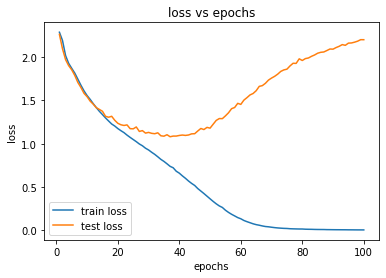

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

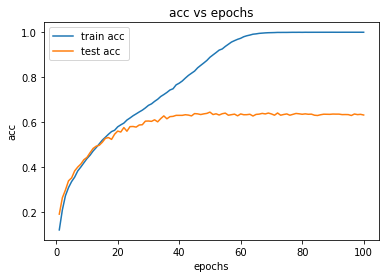

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()